In [224]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import time

class CSensor(object):
    def __init__(self,name,x = 0, y = 0):
        self.name = name
        self.x_base = x
        self.y_base = y
        self.heading =math.pi - math.atan2(self.x_base,self.y_base)        
    def set_price(self,price = 1):
        self.price = price
    def __str__(self,print_all = False):
        if print_all :
            return " ".join(str(items) for items in (self.__dict__.items()))
        else:
            return self.name
        
class CMate(CSensor):
    def __init__(self,name,x = 0, y = 0,width = 1,length = 1):
        super(CMate,self).__init__(name,x,y)
        self.width = width
        self.length = length
        self._calc_contour()
    def _calc_contour(self):
        self.mate_x = []
        self.mate_y = []
        
        self.mate_x.append(self.length/2)
        self.mate_y.append(self.width/2)
        
        self.mate_x.append(self.length/2)
        self.mate_y.append(-self.width/2)
        
        self.mate_x.append(-self.length/2)
        self.mate_y.append(-self.width/2)
        
        self.mate_x.append(-self.length/2)
        self.mate_y.append(self.width/2)
        
        self.mate_x.append(self.length/2)
        self.mate_y.append(self.width/2)
        
        self.__mate_x,self.__mate_y = self._interpolate(self.mate_x,self.mate_y)
    
    def _interpolate(self,x,y):
        rx,ry = [],[]
        dtheta = 0.05
        for i in range(len(x) - 1):
            rx.extend([(1.0 - θ) * x[i] + θ * x[i + 1] # interpolate the edges
                       for θ in np.arange(0.0, 1.0, dtheta)])
            ry.extend([(1.0 - θ) * y[i] + θ * y[i + 1]
                       for θ in np.arange(0.0, 1.0, dtheta)])            
        return rx, ry
    
    def calc_global_contour(self):
        gx = [(ix * np.cos(self.heading) + iy * np.sin(self.heading)) +
              self.x_base for (ix, iy) in zip(self.__mate_x, self.__mate_y)]
        gy = [(ix * np.sin(self.heading) - iy * np.cos(self.heading)) +
              self.y_base for (ix, iy) in zip(self.__mate_x, self.__mate_y)]
        return gx, gy
    
    def plot(self,fig):
        fig.plot(self.x_base,self.y_base,".b")
        gx,gy = self.calc_global_contour()
        plt.plot(gx,gy,"--b")
        plt.text(self.x_base,self.y_base,self.name)
        
class CFence(CMate): # Fence only influences the movement direction of human
        def plot(self,fig):
            fig.plot(self.x_base,self.y_base,".y")
            gx,gy = self.calc_global_contour()
            plt.plot(gx,gy,"--y")
            plt.text(self.x_base,self.y_base,self.name)




## Define the human class

In [225]:
class CHuman(object):
    # represent the human with a circle, which stands for the arm operation, with radius r=1
    def __init__(self,name,start_vel = 1, start_pos_x = -4,start_pos_y = -3,heading = 0):
        self.x = start_pos_x
        self.y = start_pos_y
        self.vel = start_vel
        self.name = name
        self.arm = 1
        if heading == 0:
            self.heading = math.pi - math.atan2(self.x,self.y)
        else:
            self.heading = heading
    def standing_area(self):
        #TODO: use cart2pol to segment the human better
        segment = 10
        seg_x = [self.arm * math.cos(theta) for theta in np.arange(0,np.pi*2,2*np.pi/segment)]
        seg_y = [self.arm * math.sin(theta) for theta in np.arange(0,np.pi*2,2*np.pi/segment)]
        
        gx = np.asarray(seg_x) * math.cos(self.heading)  + np.asarray(seg_y) * math.sin(self.heading) + self.x
        gy = -np.asarray(seg_x) * math.sin(self.heading) + np.asarray(seg_y) * math.cos(self.heading) + self.y
        return gx,gy
        
    def plot(self,fig):
        #fig.plot(self.x,self.y,"sg")
        plt.text(self.x,self.y,self.name)
        gx,gy = self.standing_area()
        fig.plot(gx,gy,"sr")
        human_circle = plt.Circle((self.x,self.y),self.arm,color = 'y', fill = True)
        fig.add_artist(human_circle)

## Define the Robot class

In [226]:
class CRobot(object):
    def __init__(self,name,start_vel = 1, start_pos = 0):
        self.name = name
        self.x_base = 0
        self.y_base = 0
        self.vel = start_vel
        self.pos = start_pos - math.pi/2
        self.range = 2.5
        self.__baseRadius = 0.5
        self.eef_x = self.range * math.sin(self.pos)
        self.eef_y = self.range * math.cos(self.pos)
        
    def update(self):
        self.pos -= self.vel
        self.eef_x = self.range * math.sin(self.pos)
        self.eef_y = self.range * math.cos(self.pos)
    def plot(self,fig):
        #fig.plot(self.x_base,self.y_base,"sr")
        fig.plot(self.eef_x,self.eef_y,"sr")
        base = plt.Circle((self.x_base,self.y_base),self.__baseRadius,color = 'r', fill = True)
        fig.add_artist(base)
        fig.plot([self.x_base,self.eef_x],[self.y_base,self.eef_y],"-r")
        plt.text(self.x_base-1,self.y_base+0.1,self.name)

## Define the Lidar Class

In [227]:
class CLidar(CSensor):
    # Adding the Lidar frame update frequence as wa parameter 
    def __init__(self,name,x = 0, y = 0,lidar_range =10,angle_res = 0.01,min_angle = -math.pi/2, max_angle = math.pi/2):
        super(CLidar,self).__init__(name,x,y)
        self.Lrange = lidar_range
        self.angle_res = angle_res
        self.min_angle = min_angle
        self.max_angle = max_angle
        self.range_noise = 0.01
        self.heading = math.pi - math.atan2(self.x_base,self.y_base)  
     #TODO:Check whether a point is inside of a rectangle：
    # A Chinese Blog :https://blog.csdn.net/qq_34342154/article/details/78257827
    def object_detection(self,human):
    # Note: In the first version, Lidar only detects the human
        x,y,angle,r = [],[],[],[]
        gx,gy = human.standing_area()
        for vx,vy in zip(gx,gy):
            vx = vx - self.x_base
            vy = vy - self.y_base
            vangle = math.atan2(vy,vx)
            vr = np.hypot(vx,vy)
            # Should we use Gaussian to simulate the noise?
            # vr = np.hypot(vx,vy) + * random.uniform(1.0 -self.range_noise, 1.0 + self.range_noise)
            x.append(vx)
            y.append(vy)
            angle.append(vangle)
            r.append(vr)
        distance = np.hypot(np.hypot(self.x_base - human.x, self.y_base - human.y),human.arm)
        rx,ry = self.ray_casting_filter(x,y,angle,r,distance)
        rx = [ x + self.x_base for x in rx]
        ry = [ y + self.y_base for y in ry]
        
        return rx,ry
    
    def ray_casting_filter(self,xl,yl,thetal,rangel,distance):
        rx,ry = [],[]
        rangedb = [float("inf") for _ in range(
            int(np.floor((np.pi * 2.0) / self.angle_res)) + 1)]
        # init the lidar results with "inf"

        for i in range(len(thetal)):
            angleid = int(round(thetal[i] / self.angle_res))

            if (rangedb[angleid] > rangel[i] and rangel[i] < self.Lrange and rangel[i]<distance):
                rangedb[angleid] = rangel[i]

        for i in range(len(rangedb)):
            t = i * self.angle_res
            if rangedb[i] != float("inf"):
                rx.append(rangedb[i] * np.cos(t))
                ry.append(rangedb[i] * np.sin(t))
        return rx, ry
    
        
    def plot(self,fig):
        fig.plot(self.x_base,self.y_base,"^g")
        plt.text(self.x_base,self.y_base,self.name)

class CLidarPlotter:
    def __init__(self, x, y,  colorcode = 'r'):
        self.x = x
        self.y = y
        self.color = colorcode
        
    def plot_scan(self, plt, ox, oy):
        x = [ox[i] for i in range(len(ox))]
        y = [oy[i] for i in range(len(ox))]

        for (ix, iy) in zip(x, y):
            plt.plot([self.x, ix], [self.y, iy], self.color)

In [228]:
mate = CMate('Mate1',x = 5, y = -3,width=4,length=6)
fence = CFence('Fence1', x = -2, y=-6, width = 0.5,length = 4)
lidar = CLidar('Lidar1',x=2,y=3)
robot = CRobot('Robot1',start_vel = 0.1,start_pos =0)
human = CHuman('Worker1')
lidar_plt = CLidarPlotter(x=lidar.x_base,y=lidar.y_base,colorcode='g')

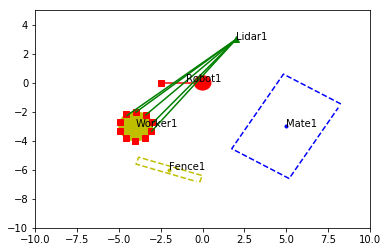

In [229]:
fig,axes = plt.subplots(1,1)
axes.cla()
axes = plt.gca()
axes.set_xlim([-10,10])
axes.set_ylim([-10,5])
#axes.axis("equal")
mate.plot(axes)
fence.plot(axes)
lidar.plot(axes)
human.plot(axes)
#print(robot.eef_x)
#robot.update()
robot.plot(axes)
time.sleep(0.01)
rx,ry = lidar.object_detection(human)
lidar_plt.plot_scan(axes, rx, ry)
    

In [230]:
arm = 1
segment = 10
heading = 0
seg_x = [arm * math.cos(theta) for theta in np.arange(0,np.pi*2,np.pi/segment)]

In [212]:
seg_y = [arm * math.sin(theta) for theta in np.arange(0,np.pi*2,np.pi/segment)]
gx = np.asarray(seg_x) * math.cos(heading)  + np.asarray(seg_y) * math.sin(heading) 

In [214]:
gx

array([ 1.00000000e+00,  9.51056516e-01,  8.09016994e-01,  5.87785252e-01,
        3.09016994e-01,  6.12323400e-17, -3.09016994e-01, -5.87785252e-01,
       -8.09016994e-01, -9.51056516e-01, -1.00000000e+00, -9.51056516e-01,
       -8.09016994e-01, -5.87785252e-01, -3.09016994e-01, -1.83697020e-16,
        3.09016994e-01,  5.87785252e-01,  8.09016994e-01,  9.51056516e-01])

In [216]:
gx.shape

(20,)